In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_blobs

%matplotlib inline

# Together

## Overview
KNN is a simple, distance based algorithm that let's us CLASSIFY data points based on what class the data points around them are. Birds of a feather...

Despite it being distance based, KNN is a *classification* algorithm. In other words, it is supervised machine learning, as it requires truth labels (the actual class/group). However it does share characteristics with clustering algorithms we will see later.

KNN *can* work with binary/categorical variables, but not without some tweaking which we do not cover here.

## Hyperparameters

Hyperparameters are parameters in our model that are NOT chosen by the algorithm (we must supply them). We can either choose them:

- based on domain expertise (knowledge about the data)
- based on the data (hyperparameter tuning)

Why do we have to use a validation set when hyperparameter tuning?


In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

bey = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")
bey.head()

# what K do I use??
predictors = ["energy", "danceability", "valence"]

X = bey[predictors]
y = bey["mode"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# create z score object
z = make_column_transformer((StandardScaler(), predictors))

# make pipeline
pipe = make_pipeline(z, knn2)
print(pipe.get_params().keys())
# this pipeline will take care of the z scoring so you don' need to z score before

# choose potential values of k
ks = {'kneighborsclassifier__n_neighbors': range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(pipe, ks, scoring = 'accuracy', cv = 5, refit = True)

knnmod = grid.fit(X_train, y_train)

y_pred_test = knnmod.predict(X_test)

y_pred_test

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'kneighborsclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1])

In [29]:
accuracy_score(y_test, y_pred_test)
print(knnmod.best_estimator_.get_params()['kneighborsclassifier__n_neighbors'])
# finding the best hyperparameter for our model

1



## KNN plotting

(this will only work with specific 2D data, if you wanted to use it for your own data you'd need to change the code to do so)

K-Nearest Neighbors is a straightforward algorithm: given a training set, classify a new (unknown) data point by counting the K nearest known points, and choosing the most common classification.

In this classwork we'll use ggplot to plot the boundaries of knn, and see how the size, shape, and overlap of clusters affect these boundries.

In [30]:
def plotKNN2D(Xdf,y,k):
    # X can only have 2 dimensions becuase of plotting
    print("------------")
    print(Xdf.columns)
    
    
    Xdf.columns = ["x0", "x1"]

    #grab the range of features for each feature
    x0_range = np.linspace(min(Xdf["x0"]) - np.std(Xdf["x0"]),
                           max(Xdf["x0"]) + np.std(Xdf["x0"]), num = 100)
    x1_range = np.linspace(min(Xdf["x1"]) - np.std(Xdf["x1"]),
                           max(Xdf["x1"]) + np.std(Xdf["x1"]), num = 100)

    #get all possible points on graph
    x0 = np.repeat(x0_range,100)
    x1 = np.tile(x1_range,100)
    x_grid = pd.DataFrame({"x0": x0, "x1": x1})

    #build model
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(Xdf,y)

    # bredict all background points
    p = knn.predict(x_grid)
    x_grid["p"] = p #add to dataframe
    
    #build the plot
    bound = (ggplot(x_grid, aes(x = "x0", y = "x1", color = "factor(p)")) +
                 geom_point(alpha = 0.2, size = 0.2) + theme_minimal() +
                 scale_color_manual(name = "Class", values = ["#E69F00", "#0072B2"]) +
                 geom_point(data = Xdf, mapping = aes(x = "x0", y = "x1", color = "factor(y)"), size = 2))
    print(bound)

# Generating Fake Clusters

## Explore

We can use the sklearn function `make_blobs()` in order to generate fake groups of data. The `centers` variable stores the xy coordinates of the centers of each of our groups as tuples. The `cluster_std` variables stores the standard deviation for each cluster. `n` is the number of data points to be generated from the clusters.

Changing `centers` changes how far apart the centers of the clusters are, whereas changing `cluster_std` changes how diffuse/spread out the clusters are. Try playing around with these numbers and using ggplot to plot the data (color by `factor(y)`). Notice how changing the numbers changes the layout of the data.

------------
Index(['x0', 'x1'], dtype='object')


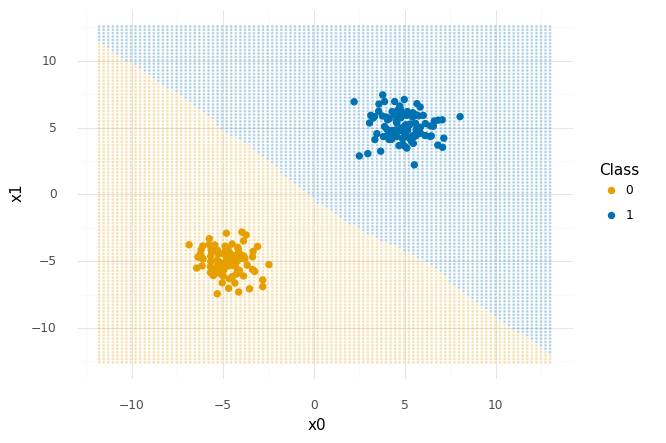

In [31]:
### variables #################################################
centers = [(-5, -5),
           (5, 5)]
cluster_std = [1, 1]
n = 200
### /variables #################################################

X, y = make_blobs(n_samples=n, cluster_std=cluster_std,
                  centers=centers, n_features=2, random_state=1)

# make it into a dataframe for ggplot
train = pd.DataFrame(X)
train.columns = ["x0", "x1"]
train["y"] = y

### YOUR CODE HERE ###
# make a scatterplot of the data we just created
plotKNN2D(train[["x0", "x1"]],y,2)


## 1.2 How does changing K affect the decision boundary?

Using the dataframe `dd` and using the `plotKNN2d()` function build KNN models with K = 1, 3, 5, 10, 20, 25, 50, 100.

**How does the decision boundary change as K changes?**

In [32]:
dd = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/knnclasswork.csv")
dd.head()

X1        X2  y
0  -1.710595 -5.593345  0
1 -14.912877 -3.722297  0
2  -8.533054 -5.908033  0
3   6.188479 -3.813313  0
4  -6.062674 -3.809560  0

------------
Index(['X1', 'X2'], dtype='object')


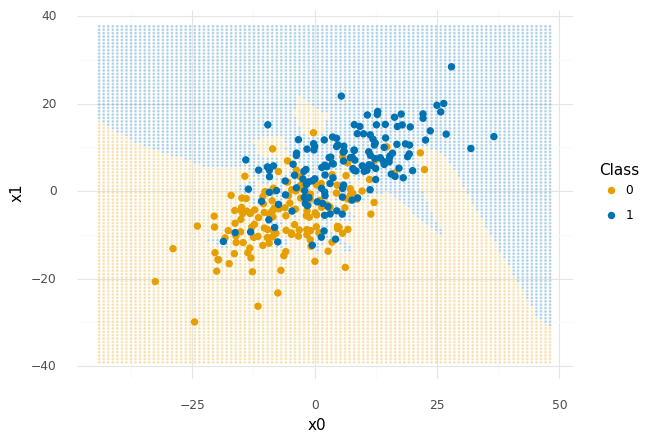


------------
Index(['X1', 'X2'], dtype='object')


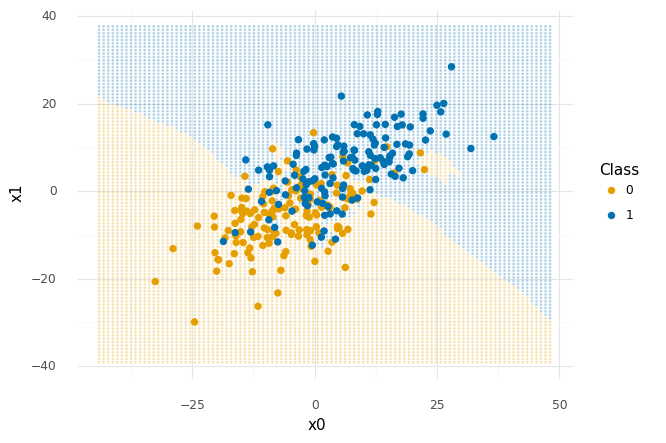


------------
Index(['X1', 'X2'], dtype='object')


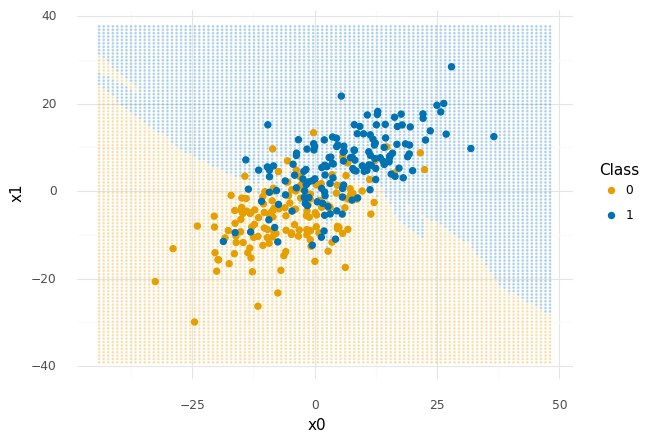


------------
Index(['X1', 'X2'], dtype='object')


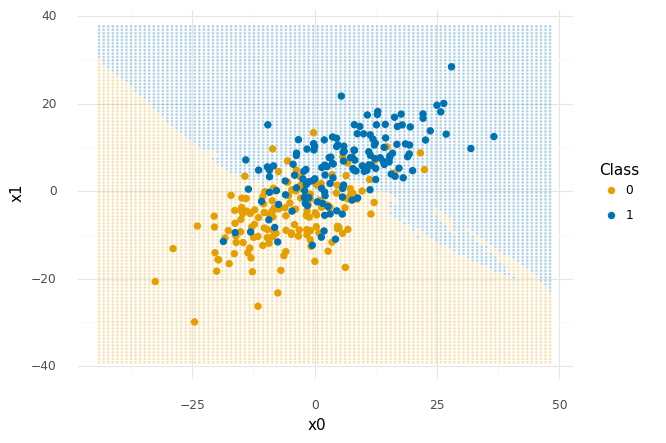


------------
Index(['X1', 'X2'], dtype='object')


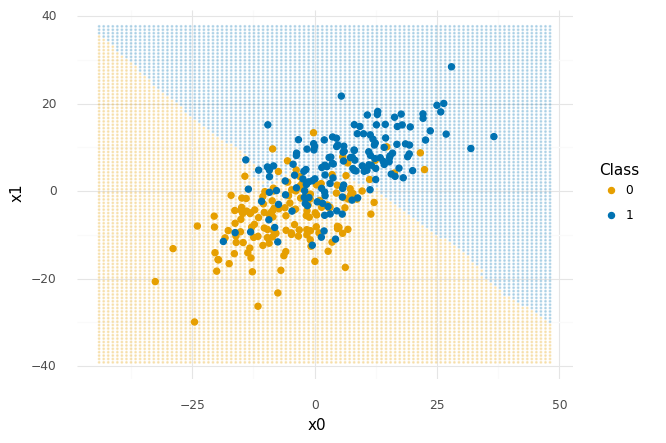


------------
Index(['X1', 'X2'], dtype='object')


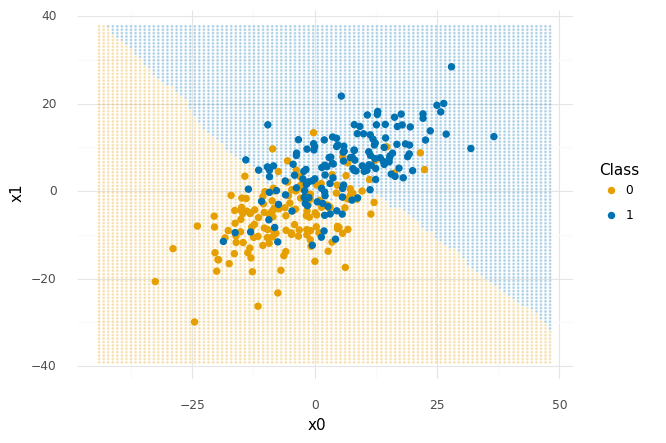


------------
Index(['X1', 'X2'], dtype='object')


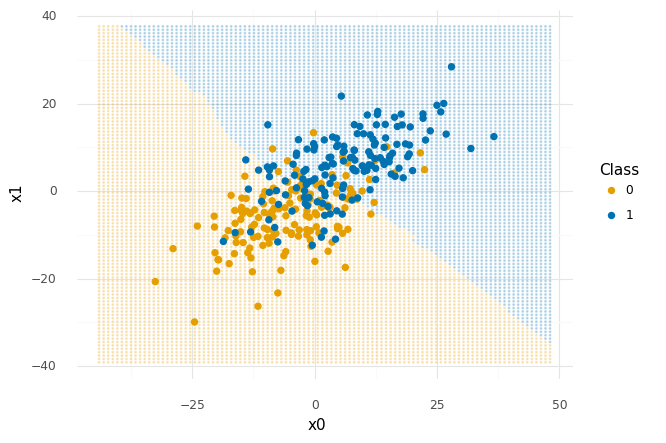


------------
Index(['X1', 'X2'], dtype='object')


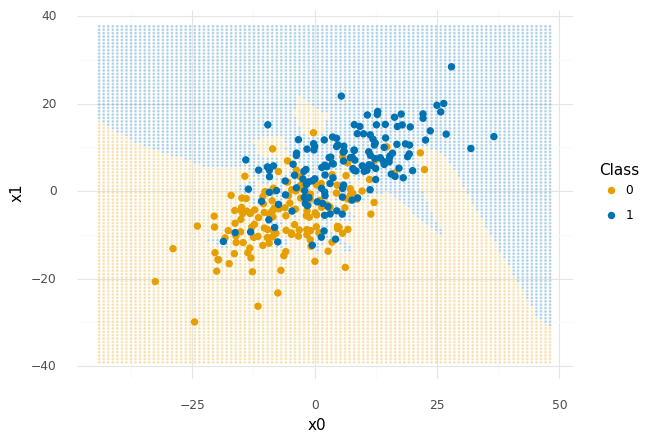

In [41]:
### YOUR CODE HERE ###

# k = 1
k1 = plotKNN2D(dd[['X1', 'X2']], dd['y'], 1)
# k = 3
k1 = plotKNN2D(dd[['X1', 'X2']], dd['y'], 3)
# k = 5
k1 = plotKNN2D(dd[['X1', 'X2']], dd['y'], 5)
# k = 10
k1 = plotKNN2D(dd[['X1', 'X2']], dd['y'], 10)
# k = 20
k1 = plotKNN2D(dd[['X1', 'X2']], dd['y'], 20)
# k = 25
k1 = plotKNN2D(dd[['X1', 'X2']], dd['y'], 25)
# k = 50
k1 = plotKNN2D(dd[['X1', 'X2']], dd['y'], 50)
# k = 100
k1 = plotKNN2D(dd[['X1', 'X2']], dd['y'], 1)

## 1.3 How does changing k affect the decision boundary (imbalanced classes)?

Now let's see how changing k affects the boundary when the groups have different numbers of samples. Using the `plotKNN2d()` function, and the `X` and `y` data generated below, examine what happens to the decision boundaries as you try different k's (try 1,3,5,10, 25, 50, and **100**).

**How does changing k affect the decision boundary when the groups are imbalanced?**

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [44]:
centers = [(-2, -2),
           (5, 5)]
cluster_std = [6, 6]

n1 = 50
n2 = 150

X, y = make_blobs(n_samples=[n1,n2], cluster_std=cluster_std,
                  centers=centers, n_features=2, random_state=1)

Xdf = pd.DataFrame(X)
Xdf.head()

### MAKE A SCATTER PLOT OF THE DATA ### 


0          1
0  3.033900   3.586612
1  4.787792  17.663630
2  7.954019   0.915931
3  5.804289  12.212329
4 -6.659940   7.114966

------------
RangeIndex(start=0, stop=2, step=1)


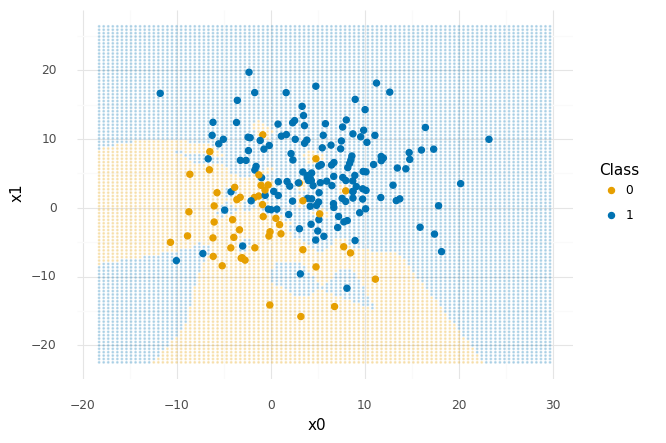


------------
Index(['x0', 'x1'], dtype='object')


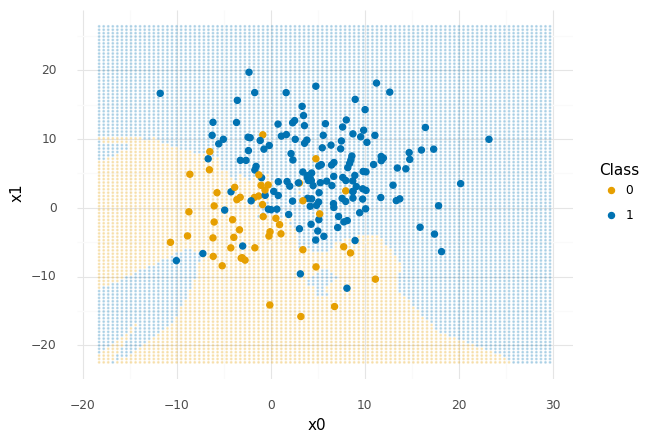


------------
Index(['x0', 'x1'], dtype='object')


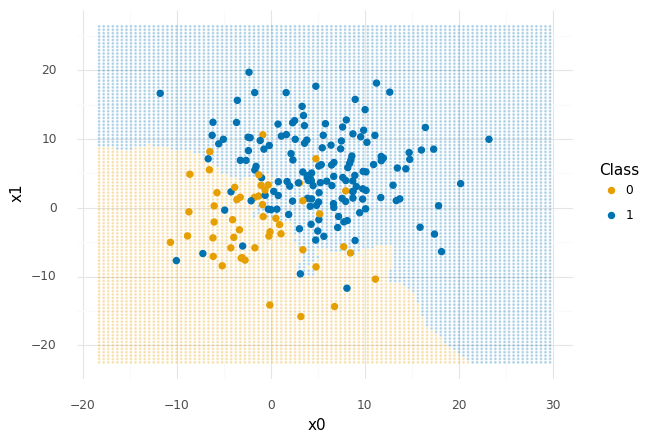


------------
Index(['x0', 'x1'], dtype='object')


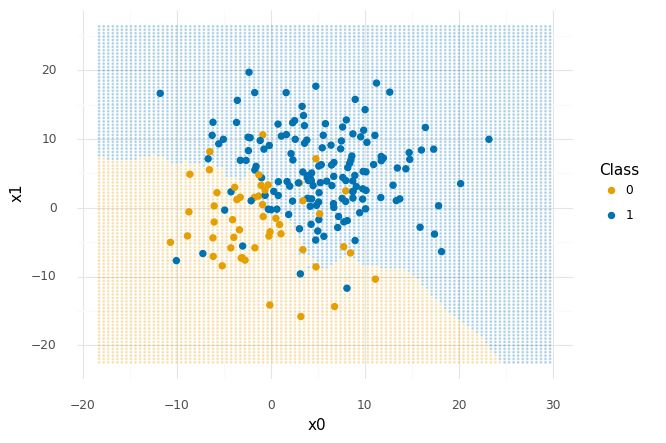


------------
Index(['x0', 'x1'], dtype='object')


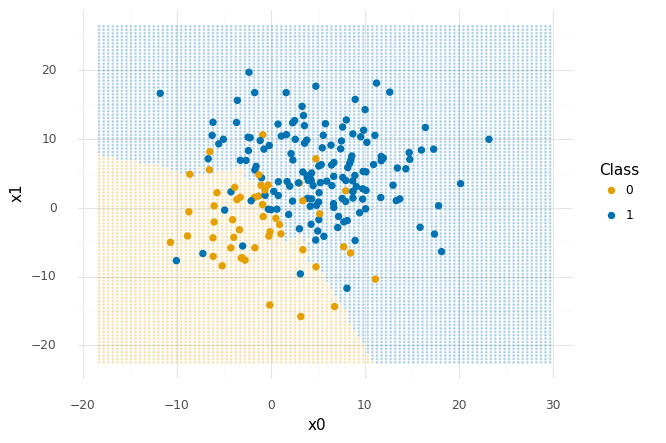


------------
Index(['x0', 'x1'], dtype='object')


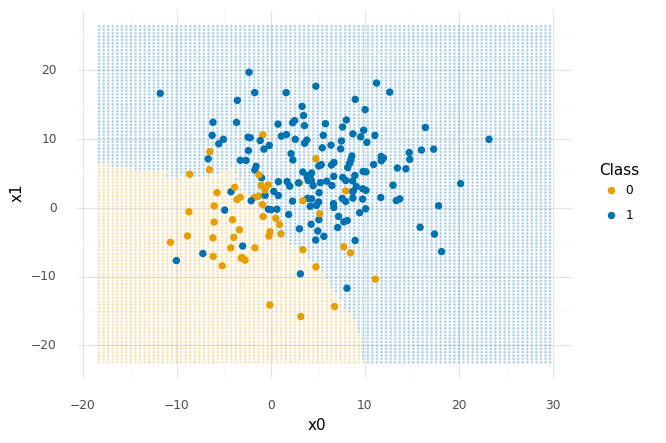


------------
Index(['x0', 'x1'], dtype='object')


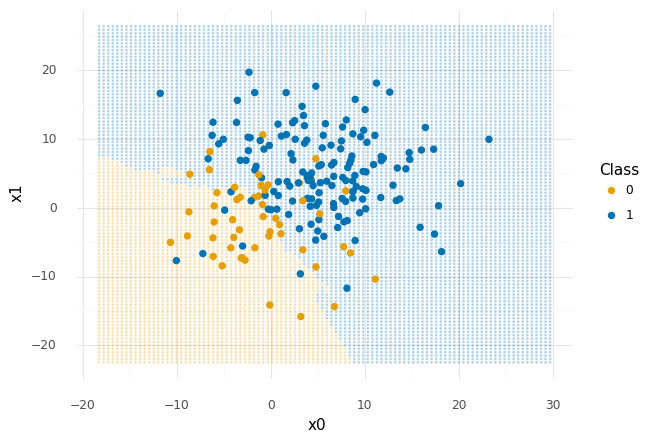


------------
Index(['x0', 'x1'], dtype='object')


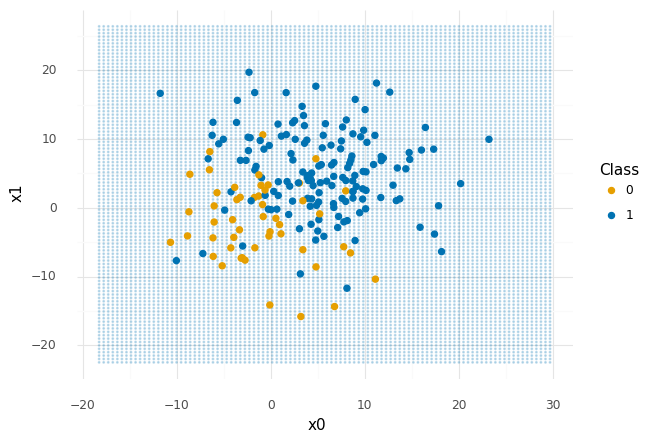

In [45]:
klist = [1,3,5,10,20,25,50,100]
for k in klist:
    plotKNN2D(Xdf, y, k)

# k = 1

# k = 3

# k = 5

# k = 10

# k = 25

# k = 50

# k = 100

# KNN

Use the `telecom_churn.csv` data from GitHub (for more information see this [link](https://www.kaggle.com/ivanhrek/telecom-churn)) and the KNN algorithm to predict `churn` in this dataset. Use TTS, and only continuous/interval variables. Z score your variables, and use `GridSearchCV()` to choose `k`.

How accurate is your model? Is it just as good at predicting people who do not churn, as people who do churn?

In [52]:
### YOUR CODE HERE ###

df = pd.read_csv('https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/telecom_churn.csv')
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

In [ ]:
predictors = ['state', 'account length', 'area code', 'phone number', 'international plan', 
'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 
'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 
'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl charge',
'customer service calls']
X = df[predictors]
y = df['churn']

n_neighbors = 5

knn = KNeighborsClassifier(n_neighbors = n_neighbors)

X_train, X_test, y_train, y_test = train_test_split

# KNN From Scratch

Write a function, `neighbors()` that takes in three arguments:

- `k`: the number of neighbors to find
- `df`: a dataframe with ONLY continuous variables (can be any # of rows or columns)
- `point`: the values of the data point you're finding neighbors for

This function should find the euclidean distance between `point` and every other data point in `df` (hint: `np.linalg.norm()`, and return a list of the indices of the `k` nearest neighbors (by indices, I mean that if the k-nearest neighbors are in the 0th, 15th, 23rd, 32nd, and 56th rows, you should return a list `[0,15,23,32,56]`). Assume that the datapoint `point` is NOT included as a row in `df`.

You may use `np.argpartition()` to find the indices of the `k` nearest neighbors. Below is an example of how it works. [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.argpartition.html) linked here.


In [37]:
# an array of numbers
ar = [1, 7, 9, 2, 0.1, 17, 17, 1.5]

# k (# of items)
k = 3

# get indices of k smallest values in ar
indices = np.argpartition(ar, k)[:k]

# check if this is correct
print(indices)

[4 0 7]


In [38]:
# test
d = pd.DataFrame({"x" : [1.449, -1.069, -0.855, -0.281, -0.994, -0.969, -1.107, -1.252, -0.524, -0.497],
                  "y" : [-1.806, -0.582, -1.109, -1.015, -0.162,  0.563,  1.648, -0.773,  1.606, -1.158]})

p = np.array([-0.75, -1])

k = 3

# if your function is working, this should output `True`
set(neighbors(k,d,p)) == set(np.array([3,2,9]))

NameError: name 'neighbors' is not defined